# E2E Testing Agent

## Overview
This notebook defines an intelligent agent designed to control a headless browser and perform end-to-end (E2E) testing on web pages. 
Users can specify the webpage URL and describe test cases in natural language. 
The agent will interpret these instructions, generate, and execute the tests.

## Motivation
In the era of AI-driven content creation, there's a growing demand for tools that can automate and simplify complex creative processes. This project aims to showcase how various AI technologies can be integrated to create a seamless workflow that transforms a simple text prompt into a dynamic visual story. By doing so, we're exploring the potential of AI in creative fields and providing a tool that could be valuable for content creators, educators, and enthusiasts alike.

## Key Components
1. [LangGraph](https://langchain-ai.github.io/langgraph/) - agent implementation
2. [Playwright](https://github.com/microsoft/playwright-python) - a Python Playwright version that we can use to generate a script that can execute the test
3. [Taipy](https://taipy.io/) - A library that we will use to spin up a simple website where we can demonstrate the capability of our agent
4. [langchain_community.agent_toolkits.PlayWrightBrowserToolkit](https://python.langchain.com/v0.1/docs/integrations/toolkits/playwright/)

## Method
The E2E tests generation process goes through the following steps:

1. **Instructions To Actions Conversion**: Convert user instruction for testing into well defined action steps that will be implemented.

2. **Playwright Code Generation**: Generate Playwright code chunks that execute specified action steps.

3. **Assertions Generation**: Creates assertions that specify whether the test have passed or not.

4. **Test Execution**: Evaluates the generate Playwright test case.

5. **Report Generation**: Creates the concise report of 


## Conclusion
TODO: write concise conclusion.

## Setup and Imports

Import necessary libraries and set up the environment.

In [9]:
import os
from typing import TypedDict, Annotated, Sequence, List
from langgraph.graph import Graph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from openai import OpenAI
import io

from langchain_core.runnables.graph import MermaidDrawMethod

from IPython.display import display, Image
import asyncio
import aiohttp
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

client = OpenAI()

## Define Data Structures

Define the structure for the graph state using TypedDict.

In [3]:
class GraphState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    instructions: Annotated[str, "Instructions for the creation of the test case"]

# TODO: Uncomment after defining OpenAPI key
# llm = ChatOpenAI(model="gpt-4")

## Define Graph Functions

Define the functions that will be used in the LangGraph workflow.

In [4]:
async def convert_user_instruction_to_actions():
    "Parse user instructions into a list of actions to be executed"
    pass

async def get_website_state(url: str):
    """Get the current DOM of the website"""
    pass

async def generate_code_for_action():
    "Generate code for a single action"
    pass

async def get_action_generation_status():
    "Decides whether to stop the generation of the actions and move to the assertions"
    pass

async def generate_assertions():
    "Generates test assertion that will be applied after action code"
    pass

async def execute_test_case():
    "Execute the whole test case with its assertions"
    pass

async def generate_test_report():
    "Generate the report from the test results"
    pass

## Set Up LangGraph Workflow

Define graph with nodes.

In [ ]:
workflow = Graph()

workflow.add_node("convert_user_instruction_to_actions", convert_user_instruction_to_actions)
workflow.add_node("get_website_state", get_website_state)
workflow.add_node("generate_code_for_action", generate_code_for_action)
workflow.add_node("get_action_generation_status", get_action_generation_status)
workflow.add_node("generate_assertions", generate_assertions)
workflow.add_node("execute_test_case", execute_test_case)
workflow.add_node("generate_test_report", generate_test_report)

Add edges to the graph.

In [21]:


workflow.set_entry_point("convert_user_instruction_to_actions")

workflow.add_edge("convert_user_instruction_to_actions", "get_website_state")
workflow.add_edge("get_website_state", "generate_code_for_action")
workflow.add_edge("generate_code_for_action", "get_action_generation_status")

workflow.add_conditional_edges("get_action_generation_status", lambda x: x, ['get_website_state', 'generate_assertions'])

workflow.add_edge("generate_assertions", "execute_test_case")
workflow.add_edge("execute_test_case", "generate_test_report")

workflow.add_edge("generate_test_report", END)



app = workflow.compile()

## Display Graph Structure

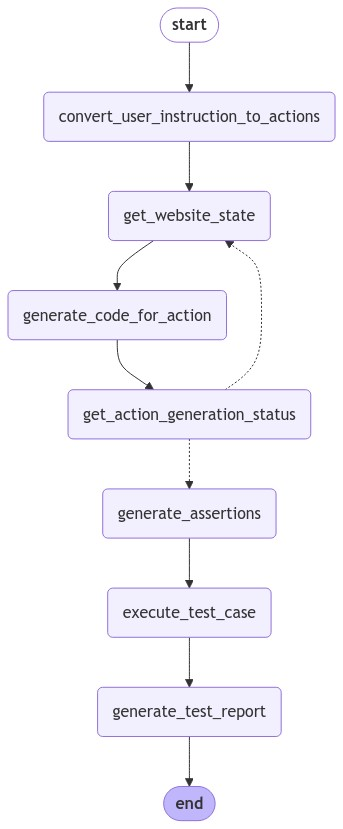

In [22]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Define Workflow Function

Define a function to run the workflow and display results.

In [14]:
# TODO: Finish the workflow
async def run_workflow(query: str):
    """Run the LangGraph workflow"""

    try:
        pass
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

## Execute Workflow

Start up a Streamlit mockup page as a subprocess (does not block notebook execution) to evaluate the workflow.

In [ ]:
import subprocess

process = subprocess.Popen(["streamlit", "run", "testing_app.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

print("Streamlit app is running in the background. You can access it at http://localhost:8501")

Run the workflow with a sample query.

In [ ]:
# TODO: Provide relevant query
query = ""
result = await run_workflow(query)

Terminate the Streamlit subprocess.

In [ ]:
process.terminate()

## Display Testing Report

Display the report from the execution of the generated tests.